In [1]:
% matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas
import torch, torch.utils.data, torchvision
import PIL
import os.path
import time
# import skimage, skimage.io
import time
import copy
from my_utils import *

In [2]:

MEAN = [0.485, 0.456, 0.406] # expected by pretrained resnet18
STD = [0.229, 0.224, 0.225] # expected by pretrained resnet18

In [3]:
# load the data and add a column for occurrences
df = pandas.read_csv('./data/train.csv')
grouped = df.groupby('Id')
df['occurrences'] =  grouped.Id.transform('count')

In [4]:
# define transformations with data augmentation.
# These are the same transformations that were used for the toy_model
transforms_augm = torchvision.transforms.Compose([
    torchvision.transforms.RandomRotation(degrees=20.0), # Data augmentation
    torchvision.transforms.RandomGrayscale(), # Data augmentation
    # torchvision.transforms.Resize((224,int(224.0*16.0/9.0))),
    torchvision.transforms.Resize((224,224)),
    torchvision.transforms.ToTensor(), # Expected by pretrained neural network
    torchvision.transforms.Normalize(MEAN, STD) # Expected by pretrained neural network
    ])

In [5]:
# Load the full dataset. Using a random subset as the validation set is difficult because
# many of the categories appear only a single time. I could try to use cross-validation instead,
# but for the moment I am just going to ignore the validation set.
full_data = WhaleDataset(df,'./data/',transform=transforms_augm)
full_dataloader = {'train': torch.utils.data.DataLoader(full_data,\
                                                   batch_size=256,\
                                                   num_workers=4,\
                                                   shuffle=True,\
                                                   sampler=None)}

In [6]:
# load the full_model
full_model = torch.load('full_model.pt')
# define the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
full_model.to(device);

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [8]:
# Choose the loss function (criterion) and optimizer.
# I make the same choice as for the toy_model.
criterion = torch.nn.CrossEntropyLoss()
# Note I am only passing the parameters from the final layer to the optimizer.
# Chances are that only the final layer is optimized, but there is some extra
# overhead because I did not declare that the other layers don't need gradients.
full_optimizer = torch.optim.Adam(full_model.fc.parameters(),lr=0.001)

In [9]:
# train the full model
full_model, loss_vals, acc_vals = train_with_restart(
    full_model,full_dataloader,criterion,full_optimizer,device,\
    use_val=False,num_epochs=30,T_max=15)

Epoch 0 / 30
Training: Elapsed time: 62.1197 Loss: 0.6385 Acc: 0.8391
Epoch 1 / 30
Training: Elapsed time: 137.8064 Loss: 0.4528 Acc: 0.8752
Epoch 2 / 30
Training: Elapsed time: 202.4542 Loss: 0.4148 Acc: 0.8877
Epoch 3 / 30
Training: Elapsed time: 266.0984 Loss: 0.4001 Acc: 0.8886
Epoch 4 / 30
Training: Elapsed time: 331.0749 Loss: 0.3583 Acc: 0.9005
Epoch 5 / 30
Training: Elapsed time: 395.7986 Loss: 0.3494 Acc: 0.9006
Epoch 6 / 30
Training: Elapsed time: 460.6015 Loss: 0.3193 Acc: 0.9048
Epoch 7 / 30
Training: Elapsed time: 523.7922 Loss: 0.3066 Acc: 0.9147
Epoch 8 / 30
Training: Elapsed time: 586.3722 Loss: 0.2811 Acc: 0.9199
Epoch 9 / 30
Training: Elapsed time: 649.3179 Loss: 0.2830 Acc: 0.9198
Epoch 10 / 30
Training: Elapsed time: 711.8443 Loss: 0.2679 Acc: 0.9253
Epoch 11 / 30
Training: Elapsed time: 774.7587 Loss: 0.2633 Acc: 0.9276
Epoch 12 / 30
Training: Elapsed time: 837.6906 Loss: 0.2588 Acc: 0.9263
Epoch 13 / 30
Training: Elapsed time: 900.2744 Loss: 0.2410 Acc: 0.9343
Epo

In [10]:
torch.save(full_model,'full_model_all_layers_retrained_gpu.pt')

<IPython.core.display.Javascript object>


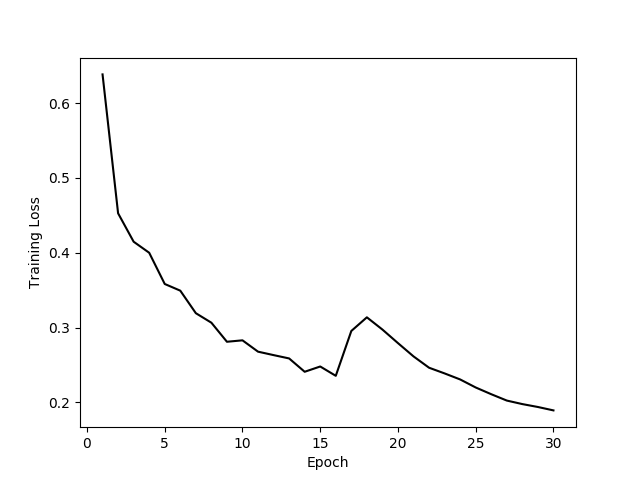

Text(0,0.5,'Training Loss')

In [11]:
plt.figure()
plt.plot(range(1,31),loss_vals['train'],'-k')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')

In [16]:
# Let's reload the full model and train only the last layer
full_model_fc = torch.load('full_model.pt')

# freeze all layers except the last layer
for param in full_model_fc.parameters():
    param.requires_grad = False
for param in full_model_fc.fc.parameters():
    param.requires_grad = True
# define the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
full_model_fc.to(device);

In [17]:
# Choose the loss function (criterion) and optimizer.
# I make the same choice as for the toy_model.
criterion = torch.nn.CrossEntropyLoss()
fc_optimizer = torch.optim.Adam(full_model_fc.fc.parameters(),lr=0.001)

In [18]:
# train the full model
full_model_fc, loss_vals_2, acc_vals_2 = train_with_restart(
    full_model_fc,full_dataloader,criterion,fc_optimizer,device,\
    use_val=False,num_epochs=30,T_max=15)

Epoch 0 / 30
Training: Elapsed time: 51.0408 Loss: 0.6294 Acc: 0.8391
Epoch 1 / 30
Training: Elapsed time: 105.2780 Loss: 0.4679 Acc: 0.8743
Epoch 2 / 30
Training: Elapsed time: 159.4911 Loss: 0.4145 Acc: 0.8843
Epoch 3 / 30
Training: Elapsed time: 213.1253 Loss: 0.3974 Acc: 0.8883
Epoch 4 / 30
Training: Elapsed time: 267.1348 Loss: 0.3709 Acc: 0.8973
Epoch 5 / 30
Training: Elapsed time: 321.3041 Loss: 0.3354 Acc: 0.9040
Epoch 6 / 30
Training: Elapsed time: 374.7180 Loss: 0.3204 Acc: 0.9099
Epoch 7 / 30
Training: Elapsed time: 426.5859 Loss: 0.3113 Acc: 0.9122
Epoch 8 / 30
Training: Elapsed time: 478.1521 Loss: 0.2865 Acc: 0.9183
Epoch 9 / 30
Training: Elapsed time: 529.9727 Loss: 0.2848 Acc: 0.9193
Epoch 10 / 30
Training: Elapsed time: 581.9603 Loss: 0.2677 Acc: 0.9235
Epoch 11 / 30
Training: Elapsed time: 633.6297 Loss: 0.2624 Acc: 0.9263
Epoch 12 / 30
Training: Elapsed time: 685.6808 Loss: 0.2523 Acc: 0.9283
Epoch 13 / 30
Training: Elapsed time: 737.2650 Loss: 0.2492 Acc: 0.9285
Epo

In [19]:
torch.save(full_model,'full_model_gpu.pt')

<IPython.core.display.Javascript object>


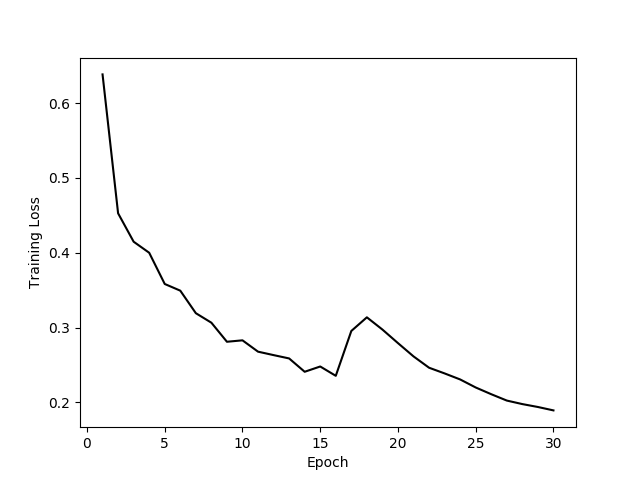

Text(0,0.5,'Training Loss')

In [20]:
plt.figure()
plt.plot(range(1,31),loss_vals['train'],'-k')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')